<a href="https://colab.research.google.com/github/davidho27941/ML_tutorial_notebook/blob/main/Build_model_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 基於TesnorFlow平台的基本模型建立
---
## 載入必要函式庫以及資料集

為了在`TensorFlow`建立模型，我們需要導入以下函式庫：

* tensorflow 
* tensorflow-datasets

以及常用的資料處理函式庫：

* Numpy 
* Pandas

我們可以透過`tf.config.list_physical_devices('GPU')`來確認GPU是否可用，並選擇在CPU或是GPU上運行我們的程式。

In [1]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---
## 匯入MNIST資料集

在此範例中，我們一樣會使用MNIST資料集進行示範。
在載入時，我們需要使用`tensorflow-datasets`的`tfds.load()`函式來抽取MNSIT資料集。並利用經由`tf.data.Dataset`的`map()`方法對資料集進行轉置；最後，我們設定批次數量為64。

我們將分別導入訓練資料集以及測試資料集作為訓練以及測試使用。

In [2]:
train_ds, train_ds_info = tfds.load(name="mnist", 
                    split='train', 
                    with_info=True, 
                    as_supervised=True)

test_ds, test_ds_info = tfds.load(name="mnist", 
                    split='test', 
                    with_info=True, 
                    as_supervised=True)

def preprocess(x, y):
    x = x/255
    x = tf.reshape(x, [784])

    y = tf.one_hot(y, 10)  
    return x, y

train_ds = train_ds.map(lambda x, y: preprocess(x, y)).batch(64)
test_ds = test_ds.map(lambda x, y: preprocess(x, y)).batch(64)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


---
## 建立順序式模型

在`TensorFlow`之中，建立順序是模型可以透過`tf.kears.Sequential()`函式來進行。主要有兩種作作法。

1. 先行建立`model`物件，並透過`model.add()`方法為模型添加結構。
2. 利用`tf.kears.Sequential`建立模型時，直接在參數內填入模型結構。

### 方法一

In [3]:
model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.InputLayer(input_shape=(784)))
model_1.add(tf.keras.layers.Dense(128, activation='relu'))
model_1.add(tf.keras.layers.Dense(64, activation='relu'))
model_1.add(tf.keras.layers.Dense(10, activation='softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


### 方法二

In [4]:
model_2 = tf.keras.Sequential([
                             tf.keras.layers.InputLayer(input_shape=(784)), 
                             tf.keras.layers.Dense(128, activation='relu'), 
                             tf.keras.layers.Dense(64, activation='relu'), 
                             tf.keras.layers.Dense(10, activation='softmax'),
                            ])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               100480    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


---
## 設定各項超參數、損失函數以及優化器



In [5]:
EPOCHS = 20 #@param {type:"slider", min:1, max:100, setp: 1}
LR = 1e-2 #@param {type:"number"}
OPTIMIZER = "adam" #@param ["adam", "SGD"]
LOSS_FN = "categorical_crossentropy" #@param ["binary_crossentropy", "categorical_crossentropy"]

if OPTIMIZER == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate = LR)
elif OPTIMIZER == 'SGD':
    momentum = 0.4 #@param {type:"slider", min:0, max:1, step:0.1}
    optimizer = tf.keras.optimizers.SGD(learning_rate = LR, 
                                        momentum = momentum)


---
## 進行訓練

在建立模型，並設定好超參數以及優化器之後，我們可以利用`model.compile()`對模型進行編譯，並利用`model.fit()`進行訓練。

### 編譯模型

在模型建立之後，我們必須利用`model.compile()`對模型的優化器、損失函數以及評估量尺等選項進行設定。

需要設定的選項如下：

* 優化器（optimizer）
* 損失函數（loss function）
* 評估量尺（metrics）

可選設定如下：
* 損失函數權重（loss weights）
* 權重矩陣（weighted metrics）
* 除錯模式（run_eagerly）

> 更多選項可以至[官方文件](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)了解

In [6]:
model_1.compile(loss = LOSS_FN, 
                optimizer = optimizer, 
                metrics=['acc'])

---
### 進行訓練

當模型編譯完成後，我們就可以開始進行訓練。訓練的方式為利用`model.fit()`函數搭配相關的參數進行訓練。`model.fit()`在訓練結束後，將會回傳一個帶有訓練歷史資訊的物件，我們可以建立一個`history`變數用以儲存回傳值，並在後續對訓練過程進行了解。

必要的參數有：

* 輸入資料以及標籤（x, y）
* 批次內資料數量（batch_size）
* 週期數量（epochs）
* 顯示模式（verbose）

> 資料輸入的形式以及設定可以參照我們先前的[介紹](https://hackmd.io/@davidho9713/HyfHBzcxY/%2F86N1lvF2SdaRkcnuuWeJTg)。

可選設定如下：
* 回測函式（callbacks）
* 驗證資料集以及標籤（validation_data）
* 驗證比例（validation_split）

> 更多的選項可至[官方文件](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)查閱。


In [7]:
history = model_1.fit(train_ds, 
            epochs = EPOCHS, 
            verbose = 1)

Epoch 1/20
938/938 [==============================] - 20s 16ms/step - loss: 0.2403 - acc: 0.9271
Epoch 2/20
938/938 [==============================] - 5s 6ms/step - loss: 0.1418 - acc: 0.9595
Epoch 3/20
938/938 [==============================] - 5s 6ms/step - loss: 0.1213 - acc: 0.9654
Epoch 4/20
938/938 [==============================] - 5s 6ms/step - loss: 0.1096 - acc: 0.9688
Epoch 5/20
938/938 [==============================] - 5s 6ms/step - loss: 0.1021 - acc: 0.9716
Epoch 6/20
938/938 [==============================] - 5s 6ms/step - loss: 0.0967 - acc: 0.9730
Epoch 7/20
938/938 [==============================] - 5s 6ms/step - loss: 0.0870 - acc: 0.9754
Epoch 8/20
938/938 [==============================] - 5s 6ms/step - loss: 0.0882 - acc: 0.9766
Epoch 9/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0790 - acc: 0.9786
Epoch 10/20
938/938 [==============================] - 5s 6ms/step - loss: 0.0779 - acc: 0.9789
Epoch 11/20
938/938 [==========================

---
## 查看學習曲線

在上一個部份，我們對模型進行了訓練，並取得了一個帶有模型訓練資訊的`history`變數。我們可以先透過內建的`__dict__`方法查看`history`物件下帶有哪些資訊。

In [8]:
print(f"Type of history: {type(history)}")

history.__dict__

Type of history: <class 'keras.callbacks.History'>


{'_chief_worker_only': None,
 '_supports_tf_logs': False,
 'epoch': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19],
 'history': {'acc': [0.9270666837692261,
   0.9594833254814148,
   0.965416669845581,
   0.968833327293396,
   0.9715999960899353,
   0.9729999899864197,
   0.9754499793052673,
   0.9765666723251343,
   0.9785666465759277,
   0.9788500070571899,
   0.9814833402633667,
   0.9806166887283325,
   0.9822499752044678,
   0.9835166931152344,
   0.9837666749954224,
   0.9825999736785889,
   0.9851333498954773,
   0.9842666387557983,
   0.9856500029563904,
   0.9856833219528198],
  'loss': [0.2402782440185547,
   0.1417832374572754,
   0.12133978307247162,
   0.10961360484361649,
   0.10210047662258148,
   0.09669706970453262,
   0.08704912662506104,
   0.08819781988859177,
   0.07898589223623276,
   0.07794850319623947,
   0.07037294656038284,
   0.07385309040546417,
   0.06801282614469528,
   0.06161478906869888,
   

由上方的執行結果，我們可以得知幾項資訊：

1. `history`變數為`keras.callbacks.History`物件，並非字典物件。雖然可以利用`__dict__`方法將內部資料以字典方式來輸出，但並無法利用字典物件所具有的`.keys()`、`.values()`以及`.items()`方法來提取資訊。

2. `history`變數下的`history`分枝儲存了以下重要資訊：

    * `acc`
    * `loss`

接下來我們將利用`acc`以及`loss`資訊來作圖，顯示訓練中的準確率以及損失值變化。

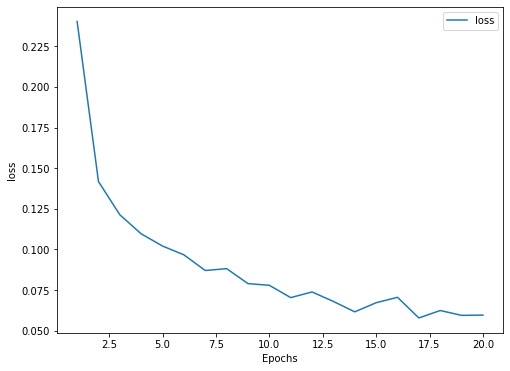

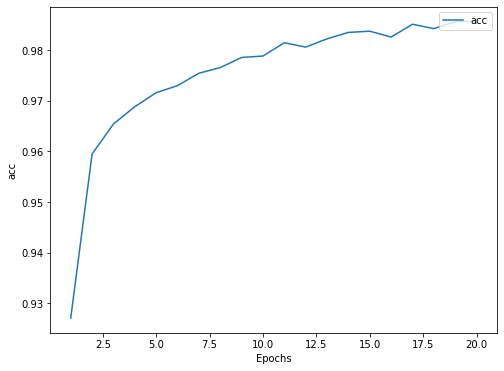

In [9]:
import matplotlib.pyplot as plt

x = [i for i in range(1, EPOCHS+1)]
plt.figure(figsize=(8,6))
plt.plot(x, history.history['loss'], label='loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(x, history.history['acc'], label='acc')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.show()


---
## 利用Functional API 建立自定義模型

先前的部份中，我們介紹了如何利用`tf.keras.Sequential`建立順序式模型。對於機器學習專案，常態下我們需要建立各式各樣的自訂模型結構。例如`ResNet-50`中所利用的殘差連結（Shortcut connection/Residual connection）就是一種無法利用順序式模型來建立的結構。我們將在此章節示範如何利用`Functional API`建立自定義的模型結構。

> 本章將不會實作殘差連結。有興趣者可以參閱此[介紹](https://medium.com/@hupinwei/%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92-resnet%E4%B9%8B%E6%AE%98%E5%B7%AE%E5%AD%B8%E7%BF%92-f3ac36701b2f)。

`Functional API`是一個由`Keras`套件所提供的實作方法，可以讓我們以更加彈性的方式建立我們所希望的模型結構。無論是非線性拓樸，或是共享層以及多重輸入/輸出都可以藉由`Functional API`來實踐。

參考我們在先前所建立的順序式模型，如果我們要利用`Functional API`來建立相同的模型，要如何來達成呢？且看以下範例。

In [10]:
# 建立輸入層
inputs = tf.keras.layers.Input(shape=(784))

# 建立全連結層
dense_1 = tf.keras.layers.Dense(128, activation='relu')(inputs)
dense_2 = tf.keras.layers.Dense(64, activation='relu')(dense_1)
outputs = tf.keras.layers.Dense(10, activation='softmax')(dense_2)


# 封裝模型
model = tf.keras.Model(inputs = inputs, 
                       outputs = outputs, 
                       name='functional_api_model')

model.summary()

Model: "functional_api_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


在上方的範例中，我們於第二行利用`tf.keras.Input`函式建立了模型的輸入點，用以承接導入模型的資料；從第五行開始，我們建立了一系列的全連結層。

利用`Functional API`建立模型時最大的不同在於，我們將會在每一層的設定時，額外於行末利用括號宣告將會輸入的資料。以第五行為例：

```
dense_1 = tf.keras.layers.Dense(128, activation='relu')(inputs)
```
在`Dense`函數的後方，與以往不同的多出了一個`(inputs)`，這寫法的意義在於，告知`Functional API`，本層的輸入函數為`inputs`所輸出的結果。我們可以在第六行以及第七行發現相同的寫法。

在完成模型結構的建構後，最重要的一步就是將模型進行封裝。在順序式模型中，因為具有明確的順序關係，`Sequential`函式將會自動封裝整個模型。在利用`Functional API`建構的模型中，我們必須自行宣告模型的輸入以及輸出，並利用`tf.keras.Model`函式對模型進行封裝。

## 編譯並進行訓練

在完成對模型的封裝以後，我們就可以利用與先前相同的方法，對模型進行編譯以及訓練。

In [11]:
model.compile(loss = LOSS_FN, 
                optimizer = optimizer, 
                metrics=['acc'])

history = model.fit(train_ds, 
            epochs = EPOCHS, 
            verbose = 1)

Epoch 1/20
938/938 [==============================] - 6s 6ms/step - loss: 0.3441 - acc: 0.9048
Epoch 2/20
938/938 [==============================] - 5s 6ms/step - loss: 0.1894 - acc: 0.9459
Epoch 3/20
938/938 [==============================] - 5s 6ms/step - loss: 0.1557 - acc: 0.9567
Epoch 4/20
938/938 [==============================] - 5s 6ms/step - loss: 0.1426 - acc: 0.9599
Epoch 5/20
938/938 [==============================] - 5s 6ms/step - loss: 0.1311 - acc: 0.9636
Epoch 6/20
938/938 [==============================] - 5s 6ms/step - loss: 0.1244 - acc: 0.9654
Epoch 7/20
938/938 [==============================] - 5s 5ms/step - loss: 0.1213 - acc: 0.9666
Epoch 8/20
938/938 [==============================] - 5s 6ms/step - loss: 0.1120 - acc: 0.9691
Epoch 9/20
938/938 [==============================] - 5s 6ms/step - loss: 0.1048 - acc: 0.9708
Epoch 10/20
938/938 [==============================] - 5s 6ms/step - loss: 0.1069 - acc: 0.9700
Epoch 11/20
938/938 [============================

同樣的，我們也能用`.fit()`函式回傳的模型訓練資料進行作圖，並顯示訓練中的準確度以及損失值變化。

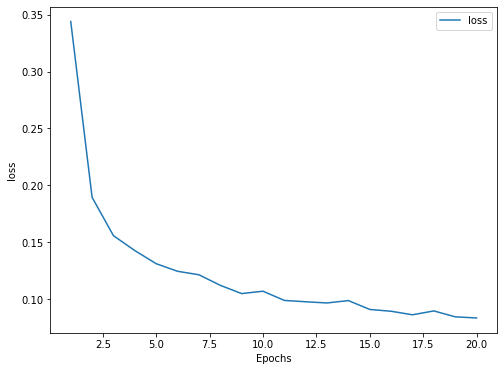

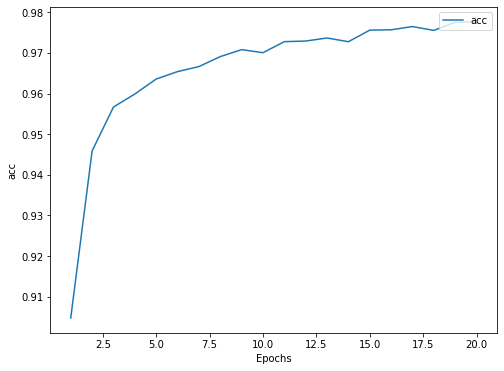

In [12]:
import matplotlib.pyplot as plt

x = [i for i in range(1, EPOCHS+1)]
plt.figure(figsize=(8,6))
plt.plot(x, history.history['loss'], label='loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(x, history.history['acc'], label='acc')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.show()


---
## 利用自定義類別建立模型

在先前的部份，我們嘗試利用`Functional API`建立自訂結構的模型。但在此之上，我們還能有更加彈性的選擇，那就是利用繼承了`tf.keras.Model`類別來進行模型的建立。此方法有幾個必要的元素：

1. 一個繼承了`tf.keras.Model`的類別。
2. 類別內必須實作`__init__`以及`call`兩個方法。
3. 類別必須利用`spuer().__init__()`方法繼承`tf.keras.Model`的初始化設定。

以下是利用此方法建立模型的範例。我們將使用與先前相同的模型結構來進行示範。

### 模型設定


In [13]:
class MLP_MODEL(tf.keras.Model):
    def __init__(self, **kargs):
        super(MLP_MODEL, self).__init__(**kargs)
        self.dense_1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense_2 = tf.keras.layers.Dense(64, activation='relu')
        self.dense_3 = tf.keras.layers.Dense(10, activation='softmax')
    def call(self, inputs):
        y = self.dense_1(inputs)
        y = self.dense_2(y)
        outputs = self.dense_3(y)
        return outputs

model = MLP_MODEL()

以上這種方法，又稱`模型子類化(model subclassing)`。有別於先前的建立模式，利用這種方式所建立的模型不需要經由`model.compile()`函式進行編譯，也不需要利用`model.fit()`進行訓練。

> 若使用者希望，也仍然可以在建立好模型後利用`.compile()`以及`.fit()`來進行訓練。

利用此方法建立的模型將具有更大的自由度以及更加彈性的架構，但相對的其設定也變得更加複雜且繁瑣。

### 設定損失函數以及優化器

首先，我們一樣要設訂我們所選用的損失函數以及優化器。予以往不同，在此方法中不能透過給定`loss='categorical_crossentropy`以及`optimizer='adam'`來進行指定，必須直接建立一個物件來進行使用。所以我們透過下方第一行以及第二行的程式碼來進行優化器和損失函數的建立。
```
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
```

在訓練過程中，每一批次的資料都會進行損失值的計算，並回傳給我們所建立的變數。而每一週期的損失值，即為該週期內所有損失值的平均。我們可以透過將計算好的損失值傳入`tf.keras.metrics.Mean()`函式進行計算，並得到該當週期的損失值。在準確率的部份，我們可以利用將預測值以及真實值傳入`tf.keras.metrics.CategoricalAccuracy()`函式來進行比對，並求出準確率。

> 為何選用`CategoricalAccuracy`？因為我們採用`one-hot`編碼對真實值進行編碼，並且輸出10個元素的陣列，故需要利用`CategoricalAccuracy`來對兩個`one-hot`編碼的陣列進行比對，並計算準確率。

In [14]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.CategoricalAccuracy(name='train_acc')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.CategoricalAccuracy(name='test_acc')

### 設定訓練以及測試流程

透過`模型子類化`建立的模型，需要利用`tf.GradientTape`函式來進行訓練；梯度的計算，模型的優化則透過先前建立的`loss_object`、`optimizer`以及相對應的`metrics`物件進行處理。

我們可以將訓練以及測試的流程包裝成函數來簡化我們的流程。在`train_step`中，首先我們先宣告
```
with tf.GradientTape() as tape:
```
來讓程式紀錄訓練過程中的梯度變化。然後利用將資料導入模型來取得預測資訊，再利用損失函數計算損失值。再取得損失值之後，我們可以計算梯度並利用梯度進行優化。最後我們將利用期間取得的損失值以及預測資訊來計算週期內的損失值以及準確率。

在測試階段，因為不需要進行梯度的計算，故可以省略呼叫`tf.GradientTape`和計算梯度以及優化模型的部份。

> 關於`tf.GradientTape()`的介紹，可以至[官方網站](https://www.tensorflow.org/api_docs/python/tf/GradientTape)閱覽。

或許有人注意到，我們在`train_step`以及`test_step`函式的定義前加了一個`@tf.function`的裝飾器。這是在`TensorFlow 2.0`以上版本中加入的動態計算圖功能，可以將使用者建立的函式在`eager`模式下進行運算，並在初次運算時建立動態圖，並在後續重複調用。

> 關於`tf.function`的詳細介紹可至[本文章](https://medium.com/%E8%BB%9F%E9%AB%94%E4%B9%8B%E5%BF%83/tensorflow-%E5%AF%A6%E5%8B%99%E8%A7%A3%E6%9E%90tf-function-1-%E7%9C%8B%E4%BC%BC%E7%B0%A1%E5%96%AE%E5%AF%A6%E8%80%8C%E8%A4%87%E9%9B%9C-d344d6a33f44)了解。

In [15]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        pred = model(images, training=True)
        loss = loss_object(labels, pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(labels, pred)

@tf.function
def test_step(images, labels):
    test_pred = model(images, training=False)
    test_losses = loss_object(labels, test_pred)

    test_loss(test_losses)
    test_acc(labels, test_pred)

### 進行訓練以及測試

在完成了訓練及測試流程的編寫夠，我們就可以透過將資料導入建立好的函式來進行訓練和測試了。在這邊需要注意的只有必須在每週其開始時將各項量尺的狀態進行重設。

In [16]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_acc.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_acc.result() * 100}'
    )

Epoch 1, Loss: 0.2736295759677887, Accuracy: 92.0, Test Loss: 0.13081921637058258, Test Accuracy: 96.1300048828125
Epoch 2, Loss: 0.11150200664997101, Accuracy: 96.71166229248047, Test Loss: 0.10535989701747894, Test Accuracy: 96.79000091552734
Epoch 3, Loss: 0.07595745474100113, Accuracy: 97.75, Test Loss: 0.09861746430397034, Test Accuracy: 96.94999694824219
Epoch 4, Loss: 0.05713047459721565, Accuracy: 98.36000061035156, Test Loss: 0.09555094689130783, Test Accuracy: 97.06999969482422
Epoch 5, Loss: 0.04439568519592285, Accuracy: 98.69667053222656, Test Loss: 0.11408955603837967, Test Accuracy: 96.6500015258789
Epoch 6, Loss: 0.03433474153280258, Accuracy: 99.01333618164062, Test Loss: 0.12005390226840973, Test Accuracy: 96.55999755859375
Epoch 7, Loss: 0.0282563716173172, Accuracy: 99.1550064086914, Test Loss: 0.11402781307697296, Test Accuracy: 96.80999755859375
Epoch 8, Loss: 0.02375872991979122, Accuracy: 99.23999786376953, Test Loss: 0.11543497443199158, Test Accuracy: 97.02999

## 結語

在本範例中，我們示範了如何用`tf.keras.Sequential()`函數、`Functional API`以及`模型子類化`來建立一個簡單的機器學習模型。接下來我們將了解如何透過建立`Callback`物件以及利用`Tensorboard`來監控模型的訓練流程。